In [1]:
import os, subprocess
import json
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pandas as pd
import pickle

#Plot settings
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
#mpl.rcParams['lines.linewidth'] = 5

#Dataset parameters
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('../../files/xsec.json') as f:
    xs = json.load(f)

with open('../../files/pmap.json') as f:
    pmap = json.load(f)

systematics = ['nominal',
               'jet_triggerUp','jet_triggerDown',
               'btagWeightUp','btagWeightDown','btagEffStatUp','btagEffStatDown',
               'UESUp','UESDown','JESUp','JESDown','JERUp','JERDown',
              ]

## Get significance from combine scan

In [2]:
#Open one file and extract the thresholds and significance
def open_file_and_extract(file_path):
    
    thresholds_temp = []
    thresholds = []
    significance = []
    status = []
    
    with open(file_path) as f:
        lines = f.read().splitlines()
        
    for x in lines:
        
        if x.endswith('>>>') and not x.startswith('>>>'):
            thresholds_temp.append([float(y[5:]) for y in x[:-4].split(';')])
            
        if x.startswith('Significance:'):            
            significance.append(float(x[14:]))
            thresholds.append(thresholds_temp[-1])
            
        if x.startswith('INFO: (function: improveOnce) CascadeMinimizer.cc: 211 -- Minimisation finished with status=-1'): status.append(-1)
        if x.startswith('INFO: (function: improveOnce) CascadeMinimizer.cc: 211 -- Minimisation finished with status=0'): status.append(0)
        
    
    for i in range(len(significance)):
        if status[2*i] + status[2*i+1]< 0:
            significance[i] = -1
        
#     print("Thresholds: {}. Length: {}".format(thresholds,len(thresholds)))
#     print("Significance: ", significance)
#     print("Status: {}. Length: {}".format(status, len(status)))
    
    return thresholds, significance, status
    
def scan_logs_out(log_dir):
    
    ddb_thres = []
    ddc_thres = []
    all_sign = []
    all_status = []
    
    #Loop over the files
    for file in os.listdir(log_dir):
        
        filename = os.fsdecode(file)
        if filename.endswith(".out"):
            local_thres, local_sign, local_status = open_file_and_extract(os.path.join(log_dir,filename))
            
            if len(local_sign) > 0:
                    ddb_thres += [x[0] for x in local_thres]
                    ddc_thres += [x[1] for x in local_thres]
                    all_sign += local_sign
                    all_status += local_status
#             elif len(local_sign) < 10:
#                 print("local thres:", local_thres)
#                 print("Local sign: ", local_sign)
                
    return np.asarray(ddb_thres), np.asarray(ddc_thres), np.asarray(all_sign), np.asarray(all_status)
            
ddb, ddc, sign, status = scan_logs_out("logs/")

(0.02, 1.0)

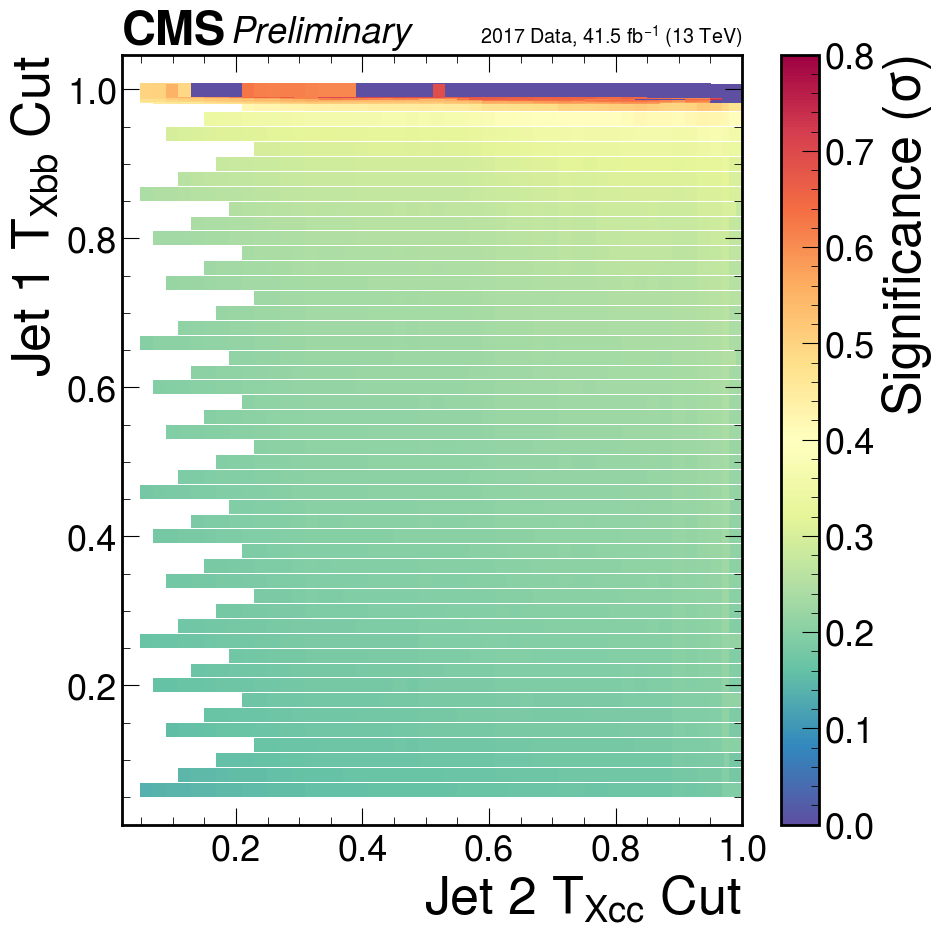

In [3]:
fig, ax = plt.subplots()
im = ax.scatter(ddc, ddb, c=sign, s=100, marker='s', cmap='Spectral_r',linewidths=0, vmin=0., vmax=0.8)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'Significance ($\sigma$)')

hep.cms.text("Preliminary")
hep.cms.lumitext(r"2017 Data, 41.5 $fb^{-1}$ (13 TeV)", fontsize=15)

plt.xlabel(r"Jet 2 $T_{Xcc}$ Cut")
plt.ylabel(r"Jet 1 $T_{Xbb}$ Cut")
plt.xlim([0.02,1])
#plt.xscale('log')

In [4]:
d = {'Jet 1 b': ddb, 'Jet 2 c': ddc, 'significance':sign}
df = pd.DataFrame(data=d)

In [5]:
df['significance']

0       0.137067
1       0.139514
2       0.140819
3       0.142799
4       0.144136
          ...   
5354   -1.000000
5355   -1.000000
5356    0.000000
5357   -1.000000
5358   -1.000000
Name: significance, Length: 5359, dtype: float64

In [38]:
df_print.iloc[0]['Jet 1 b']

0.99265

In [11]:
df_print = df[(df['significance'] > 0.6)]

for i in range(len(df_print)):
    print("---------")
    print("B Threshold: ",df_print.iloc[i]['Jet 1 b'])
    print("C Threshold: ", df_print.iloc[i]['Jet 2 c'])
    print("Significance: ", df_print.iloc[i]['significance'])

---------
B Threshold:  0.99286
C Threshold:  0.72
Significance:  0.634954
---------
B Threshold:  0.99286
C Threshold:  0.74
Significance:  0.631807
---------
B Threshold:  0.99286
C Threshold:  0.76
Significance:  0.626369
---------
B Threshold:  0.99286
C Threshold:  0.78
Significance:  0.624356
---------
B Threshold:  0.99286
C Threshold:  0.8
Significance:  0.625818
---------
B Threshold:  0.99286
C Threshold:  0.82
Significance:  0.626395
---------
B Threshold:  0.99286
C Threshold:  0.84
Significance:  0.627676
---------
B Threshold:  0.99286
C Threshold:  0.86
Significance:  0.621477
---------
B Threshold:  0.99286
C Threshold:  0.88
Significance:  0.610811
---------
B Threshold:  0.99265
C Threshold:  0.86
Significance:  0.621434
---------
B Threshold:  0.99265
C Threshold:  0.88
Significance:  0.61152
---------
B Threshold:  0.99265
C Threshold:  0.92
Significance:  0.625177
---------
B Threshold:  0.99265
C Threshold:  0.94
Significance:  0.613931
---------
B Threshold:  0.9

In [5]:
#Define the working points (for 2017 only)
Xbb_points = [0.9105, 0.9714, 0.9870]
Xcc_points = [0.9347, 0.9765, 0.9909]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


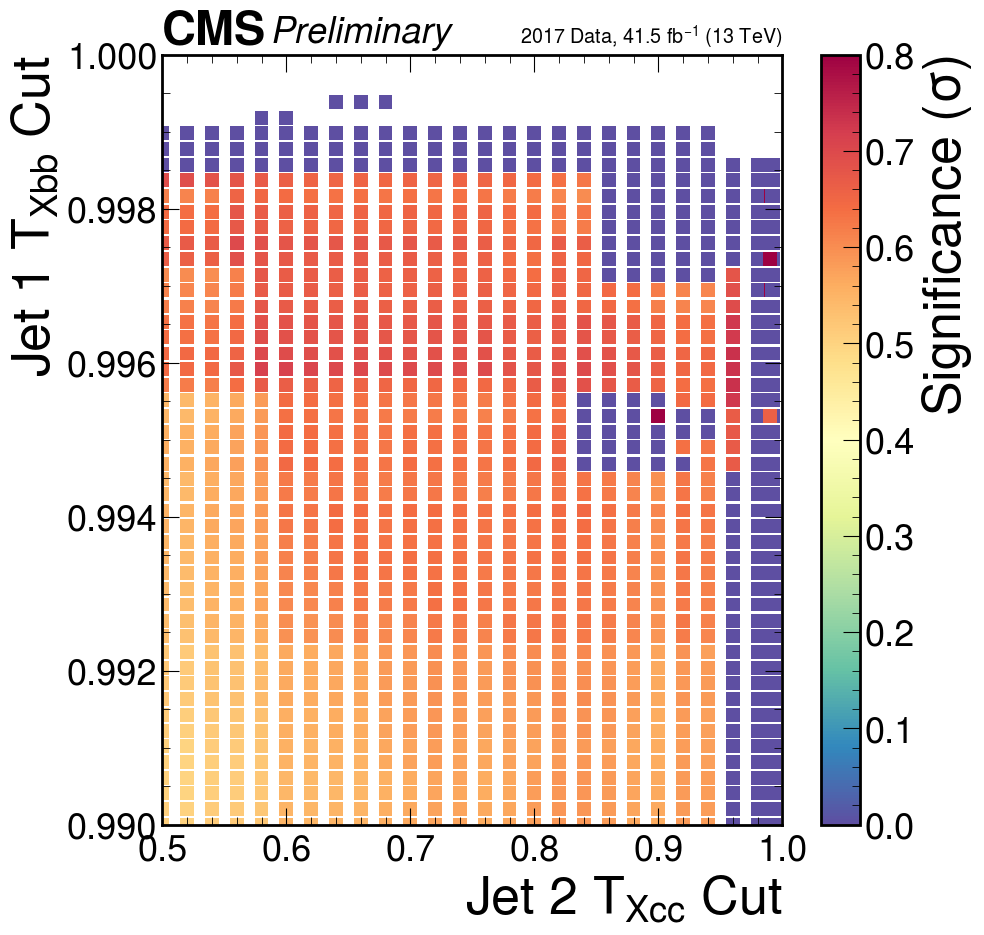

In [10]:
fig, ax = plt.subplots()
im = ax.scatter(ddc, ddb, c=sign, s=100, marker='s', cmap='Spectral_r',linewidths=0, vmin=0., vmax=0.8)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'Significance ($\sigma$)')

#Plot the working points
# legend_count = 0

# for Xbb in Xbb_points:
#     for Xcc in Xcc_points:
#         if legend_count == 0:
#             plt.scatter(Xcc, Xbb, s=600, marker='*',
#                         color ='firebrick', label = r"Working points")
#         else:
#             plt.scatter(Xcc, Xbb, s=600, marker='*',
#                         color ='firebrick')
#         legend_count += 1

hep.cms.text("Preliminary")
hep.cms.lumitext(r"2017 Data, 41.5 $fb^{-1}$ (13 TeV)", fontsize=15)

plt.xlabel(r"Jet 2 $T_{Xcc}$ Cut")
plt.ylabel(r"Jet 1 $T_{Xbb}$ Cut")
plt.xlim([0.5,1])
plt.ylim(0.99,1)
plt.legend(loc='best')
#plt.xscale('log')